In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.multitest as smm

In [2]:
df = pd.read_csv('gene_high_throughput_sequencing.csv')
df.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [3]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


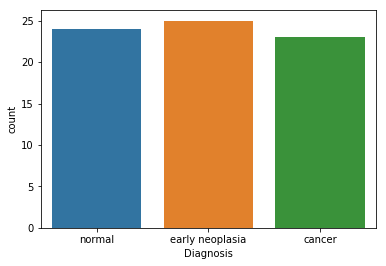

In [4]:
import seaborn as sns
sns.countplot(x="Diagnosis", data=df)

In [5]:
df_normal = df[df.Diagnosis == 'normal']
df_neoplasia = df[df.Diagnosis == 'early neoplasia']
df_cancer = df[df.Diagnosis == 'cancer']

In [6]:
df.Diagnosis.value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

In [7]:
global compare_normal_neoplasia
compare_normal_neoplasia = []
for col in df.columns[2:]:
    compare_normal_neoplasia.append([stats.ttest_ind(df_normal[col], df_neoplasia[col], equal_var = False).statistic, \
                                   stats.ttest_ind(df_normal[col], df_neoplasia[col], equal_var = False).pvalue])

In [8]:
ttest_normal_neoplasia = pd.DataFrame(compare_normal_neoplasia, index = df.columns[2:], columns = ['statistic', 'p'])

In [9]:
pcount_1 = ttest_normal_neoplasia[ttest_normal_neoplasia.p < 0.05].p.count()

In [10]:
global compare_neoplasia_cancer
compare_neoplasia_cancer = []
for col in df.columns[2:]:
    compare_neoplasia_cancer.append([stats.ttest_ind(df_neoplasia[col], df_cancer[col], equal_var = False).statistic, \
                                   stats.ttest_ind(df_neoplasia[col], df_cancer[col], equal_var = False).pvalue])
ttest_neoplasia_cancer = pd.DataFrame(compare_neoplasia_cancer, index = df.columns[2:], columns = ['statistic', 'p'])    

In [11]:
pcount_2 = ttest_neoplasia_cancer[ttest_neoplasia_cancer.p < 0.05].p.count()

In [12]:
list_1 = list(ttest_normal_neoplasia[ttest_normal_neoplasia.p < 0.05].index)

In [13]:
for x in list(ttest_neoplasia_cancer[ttest_neoplasia_cancer.p < 0.05].index):
    list_1.append(x)

In [14]:
genes_differ = len(set(list_1))

In [15]:
with open("bioinformatics_problem1_1.txt", "w") as fout:
        fout.write(str(pcount_1))
with open("bioinformatics_problem1_2.txt", "w") as fout:
        fout.write(str(pcount_2))

In [18]:
bon_holm_1 = smm.multipletests(ttest_normal_neoplasia.p, alpha=0.05/2, method='holm')

In [22]:
bon_holm_1 = pd.DataFrame(np.transpose(bon_holm_1[:2]), index = df.columns[2:], columns = ['reject', 'p-corrected'])

In [26]:
bon_holm_gen_1 = list(bon_holm_1[bon_holm_1['p-corrected'] < 0.05/2].index)

In [27]:
bon_holm_2 = smm.multipletests(ttest_neoplasia_cancer.p, alpha=0.05/2, method='holm')
bon_holm_2 = pd.DataFrame(np.transpose(bon_holm_2[:2]), index = df.columns[2:], columns = ['reject', 'p-corrected'])
bon_holm_gen_2 = list(bon_holm_2[bon_holm_2['p-corrected'] < 0.05/2].index)

In [30]:
global FC_1
FC_1 = []
for gene in bon_holm_gen_1:
    T = np.mean(df_neoplasia[gene])
    C = np.mean(df_normal[gene])
    if T > C:
        FC_1.append(T/C)
    else:
        FC_1.append(-C/T)

In [40]:
with open("bioinformatics_problem2_1.txt", "w") as fout:
        fout.write(str(sum([1 if abs(elem) > 1.5 else 0 for elem in FC_1 ])))


In [38]:
global FC_2
FC_2 = []
for gene in bon_holm_gen_2:
    C = np.mean(df_neoplasia[gene])
    T = np.mean(df_cancer[gene])
    if T > C:
        FC_2.append(T/C)
    else:
        FC_2.append(-C/T)

In [41]:
with open("bioinformatics_problem2_2.txt", "w") as fout:
        fout.write(str(sum([1 if abs(elem) > 1.5 else 0 for elem in FC_2 ])))

In [42]:
bon_bh_1 = smm.multipletests(ttest_normal_neoplasia.p, alpha=0.05/2, method='fdr_bh')
bon_bh_1 = pd.DataFrame(np.transpose(bon_bh_1[:2]), index = df.columns[2:], columns = ['reject', 'p-corrected'])
bon_bh_1_gen_1 = list(bon_bh_1[bon_bh_1['p-corrected'] < 0.05/2].index)
bon_bh_2 = smm.multipletests(ttest_neoplasia_cancer.p, alpha=0.05/2, method='fdr_bh')
bon_bh_2 = pd.DataFrame(np.transpose(bon_bh_2[:2]), index = df.columns[2:], columns = ['reject', 'p-corrected'])
bon_bh_gen_2 = list(bon_bh_2[bon_bh_2['p-corrected'] < 0.05/2].index)
global FC_1_bh
FC_1_bh = []
for gene in bon_bh_1_gen_1:
    T = np.mean(df_neoplasia[gene])
    C = np.mean(df_normal[gene])
    if T > C:
        FC_1_bh.append(T/C)
    else:
        FC_1_bh.append(-C/T)
with open("bioinformatics_problem3_1.txt", "w") as fout:
        fout.write(str(sum([1 if abs(elem) > 1.5 else 0 for elem in FC_1_bh ])))

In [43]:
global FC_2_bh
FC_2_bh = []
for gene in bon_bh_gen_2:
    C = np.mean(df_neoplasia[gene])
    T = np.mean(df_cancer[gene])
    if T > C:
        FC_2_bh.append(T/C)
    else:
        FC_2_bh.append(-C/T)
with open("bioinformatics_problem3_2.txt", "w") as fout:
        fout.write(str(sum([1 if abs(elem) > 1.5 else 0 for elem in FC_2_bh ])))